In [1]:
try:
    import mlagents
    print("ml-agents already installed")
except ImportError:
    !python -m pip install -q mlagents==0.27.0
    print("Installed ml-agents")

ml-agents already installed


# Q-Learning Keras

In [13]:
import random
import tensorflow as tf
import numpy as np
import datetime
import traceback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Conv2D, Flatten, concatenate
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import Huber, LogCosh, CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.environment import ActionTuple, BaseEnv

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Deep Q-Learning

In [27]:
# Configuration paramaters for the whole setup
gamma = 0.01  # Discount factor for past rewards
epsilon = 0.5  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
max_steps_per_episode = 10000
batch_size = 128
behavior_name = 'AlphaRomeo?team=0'

In [28]:
num_actions = 8


def create_q_model():
    with tf.device('GPU:0'):
        
        inputs = Input(shape=(84, 84, 1,))

        layer1 = Conv2D(64, 8, strides=4, activation="relu")(inputs)
        layer2 = Conv2D(128, 4, strides=2, activation="relu")(layer1)
        layer3 = Conv2D(128, 9, strides=1, activation="relu")(layer2)

        conv_output = Flatten()(layer3)
        
        conv_output_model = Model(inputs=inputs, outputs=conv_output)
        
        numerical_inputs = Input(shape=(2))
        layer4 = Dense(64, activation="relu")(numerical_inputs)
        numerical_output = Dense(128, activation="relu")(layer4)
        
        numerical_output_model = Model(inputs=numerical_inputs, outputs=numerical_output)
        
        combined = concatenate([conv_output_model.output, numerical_output_model.output])

        layer5 = Dense(512, activation="relu")(combined)
        action = Dense(num_actions, activation="linear")(layer5)

        return Model(inputs=[conv_output_model.input, numerical_output_model.input], outputs=action)


model = create_q_model()

model_target = create_q_model()

model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 84, 84, 1)]  0           []                               
                                                                                                  
 conv2d_33 (Conv2D)             (None, 20, 20, 64)   4160        ['input_22[0][0]']               
                                                                                                  
 conv2d_34 (Conv2D)             (None, 9, 9, 128)    131200      ['conv2d_33[0][0]']              
                                                                                                  
 input_23 (InputLayer)          [(None, 2)]          0           []                               
                                                                                           

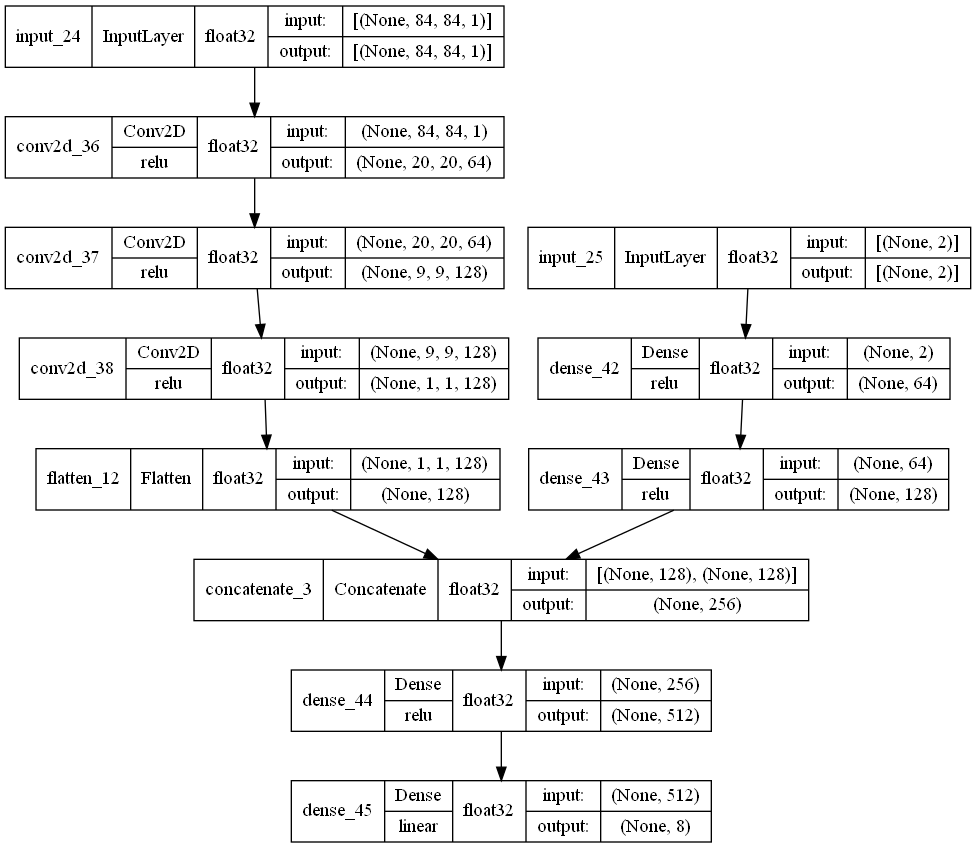

In [29]:
plot_model(model_target, show_shapes=True, show_dtype=True, show_layer_activations=True)

In [32]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

# Memórias de repetição de experiência
action_history = []
state_conv_history = []
state_num_history = []
state_conv_next_history = []
state_num_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 100
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 10000
# Train the model after 4 actions
update_after_actions = 20
# How often to update the target network
update_target_network = 100
# Using huber loss for stability
loss_function =Huber()

In [35]:
env = UnityEnvironment(file_name="Alpha Romeo", seed=1, side_channels=[])

log_folder = 'logs/{}'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = tf.summary.create_file_writer(log_folder)

# tf.debugging.experimental.enable_dump_debug_info(log_folder, tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)

try:
    while True:  # Run until solvedloss_function
        with writer.as_default():
            env.reset()
            done = False
            decision_steps, terminal_steps = env.get_steps(behavior_name)
            if decision_steps:
                state_conv = decision_steps[0].obs[0]
                state_num = decision_steps[0].obs[1]
            if terminal_steps:
                done = True                
                state_conv = decision_steps[0].obs[0]
                state_numerical = decision_steps[0].obs[1]
                         
            episode_reward = 0

            for timestep in range(1, max_steps_per_episode):
                # env.render(); Adding this line would show the attempts
                # of the agent in a pop up window.
                frame_count += 1

                # Use epsilon-greedy for exploration
                if  epsilon > np.random.rand(1)[0]:
                    # Take random action
                    action = random.choice([1,2,3,4,5,6,7,8])
                    
                else:
                    # Predict action Q-values
                    # From environment state
                    state_conv_tensor = tf.convert_to_tensor(state_conv)
                    state_num_tensor = tf.convert_to_tensor(state_num)
                    state_conv_tensor = tf.expand_dims(state_conv_tensor, 0)
                    state_num_tensor = tf.expand_dims(state_num_tensor, 0)
                    action_probs = model([state_conv_tensor, state_num_tensor], training=False)
                    # Take best action
                    action = action_probs[0]
                    action = int(tf.argmax(action)+1)
                    

                # Decay probability of taking random action
                epsilon -= epsilon_interval / epsilon_greedy_frames
                epsilon = max(epsilon, epsilon_min)

                # Apply the sampled action in our environment

                action_tuple = ActionTuple()
                action_tuple.add_discrete(np.array([[action]]))
                
                env.set_actions(behavior_name, action_tuple)
                
                env.step()

                decision_steps, terminal_steps = env.get_steps(behavior_name)

                if terminal_steps:
                    done = True
                    env.reset()
                    decision_steps, terminal_steps = env.get_steps(behavior_name)
                    state_conv_next = decision_steps[0].obs[0]
                    state_num_next = decision_steps[0].obs[1]
    #                 decision_steps, terminal_steps = env.get_steps(behavior_name)
                    break

                else:
                    state_conv_next = decision_steps[0].obs[0]
                    state_num_next = decision_steps[0].obs[1]


                reward = decision_steps[0].reward
        #         state_next = np.array(state_next)

                episode_reward += reward
                # Save actions and states in replay buffer
                action_history.append(action)
                state_conv_history.append(state_conv)
                state_num_history.append(state_num)
                state_conv_next_history.append(state_conv_next)
                state_num_next_history.append(state_num_next)
                done_history.append(done) 
                rewards_history.append(reward)
                state_conv = state_conv_next
                state_num = state_num_next

                # Update every fourth frame and once batch size is over 32
                if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

                    # Selecionar índices aleatóriamente
                    indices = np.random.choice(range(len(done_history)), size=batch_size)

                    # Usando list comprehension para buscar os valores dos índices selecionados
                    state_conv_sample = np.array([state_conv_history[i] for i in indices])
                    state_num_sample = np.array([state_num_history[i] for i in indices])
                    state_conv_next_sample = np.array([state_conv_next_history[i] for i in indices])
                    state_num_next_sample = np.array([state_num_next_history[i] for i in indices])
                    rewards_sample = [rewards_history[i] for i in indices]
                    action_sample = [action_history[i] for i in indices]
                    done_sample = tf.convert_to_tensor(
                        [float(done_history[i]) for i in indices]
                    )

                    # Build the updated Q-values for the sampled future states
                    # Use the target model for stability
                    state_num_next_sample = tf.reshape(state_num_next_sample, [-1, 2])
                    future_rewards = model_target.predict([np.array(state_conv_next_sample), np.array(state_num_next_sample)])

                    # Q value = reward + discount factor * expected future reward
                    updated_q_values = rewards_sample + gamma * tf.reduce_max(
                        future_rewards, axis=1
                    )

                    # If final frame set the last value to -1
                    updated_q_values = updated_q_values * (1 - done_sample) - done_sample

                    # Create a mask so we only calculate loss on the updated Q-values

                    masks = tf.one_hot(action_sample, num_actions)

                    with tf.GradientTape() as tape:
                        # Train the model on the states and updated Q-values
                        q_values = model([np.array(state_conv_sample), np.array(state_num_sample)])


                        # Apply the masks to the Q-values to get the Q-value for action taken
                        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)

                        # Calculate loss between new Q-value and old Q-value

                        loss = loss_function(updated_q_values, q_action)

                    # Backpropagation
                    grads = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(grads, model.trainable_variables))

                if frame_count % update_target_network == 0:
                    # update the the target network with new weights
                    model_target.set_weights(model.get_weights())
                    # Log details
                    template = "running reward: {:.2f} at episode {}, frame count {}"
                    print(template.format(running_reward, episode_count, frame_count))
                    tf.summary.scalar(name="reward", data=running_reward, step=episode_count)
                    tf.summary.scalar(name="epsilon", data=epsilon, step=episode_count)
                    tf.summary.scalar(name="frame_count", data=frame_count, step=episode_count)
                    dqn_variable = model.trainable_variables
                    tf.summary.histogram(name="dqn_variables", data=tf.convert_to_tensor(dqn_variable[0]), step=episode_count)
                    tf.summary.histogram(name="actions", data=action, step=episode_count)
                    convs = np.reshape(model.layers[4].get_weights()[0], (-1, 9, 9, 1))
                    tf.summary.image("Training data", data=convs[:5, :, :, :], step=episode_count)
                    writer.flush()
                    
            # Limit the state and reward history
            if len(rewards_history) > max_memory_length:
                del rewards_history[:1]
                del state_conv_history[:1]
                del state_num_history[:1]
                del state_conv_next_history[:1]
                del state_num_next_history[:1]
                del action_history[:1]
                del done_history[:1]

            if done:
                env.reset()
                done = False


            # Update running reward to check condition for solving
            episode_reward_history.append(episode_reward)
            if len(episode_reward_history) > 100:
                del episode_reward_history[:1]
            running_reward = np.mean(episode_reward_history)

            episode_count += 10

            if running_reward > 500000:  # Condition to consider the task solved
                print("Solved at episode {}!".format(episode_count))
                break
except:
    print(traceback.print_exc())
    writer.close()
    env.close()

running reward: 0.00 at episode 0, frame count 200
running reward: 0.00 at episode 0, frame count 300
running reward: -150000.00 at episode 10, frame count 400
running reward: -83000.00 at episode 20, frame count 500
running reward: -53750.00 at episode 40, frame count 600
running reward: -53750.00 at episode 40, frame count 700
running reward: -42166.67 at episode 60, frame count 800
running reward: -38428.57 at episode 70, frame count 900
running reward: -40750.00 at episode 80, frame count 1000
running reward: -41000.00 at episode 90, frame count 1100
running reward: -41500.00 at episode 100, frame count 1200
running reward: -43545.45 at episode 110, frame count 1300
running reward: -41250.00 at episode 120, frame count 1400
running reward: -39615.38 at episode 130, frame count 1500
running reward: -36071.43 at episode 140, frame count 1600
running reward: -37800.00 at episode 150, frame count 1700
running reward: -33529.41 at episode 170, frame count 1800
running reward: -33529.41 

Traceback (most recent call last):
  File "C:\Users\carlo\AppData\Local\Temp/ipykernel_26220/3261026035.py", line 56, in <module>
    env.step()
  File "C:\Users\carlo\anaconda3\lib\site-packages\mlagents_envs\timers.py", line 305, in wrapped
    return func(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\mlagents_envs\environment.py", line 338, in step
    self._update_state(rl_output)
  File "C:\Users\carlo\anaconda3\lib\site-packages\mlagents_envs\environment.py", line 291, in _update_state
    self._env_state[brain_name] = steps_from_proto(
  File "C:\Users\carlo\anaconda3\lib\site-packages\mlagents_envs\timers.py", line 305, in wrapped
    return func(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\mlagents_envs\rpc_utils.py", line 330, in steps_from_proto
    _process_maybe_compressed_observation(
  File "C:\Users\carlo\anaconda3\lib\site-packages\mlagents_envs\timers.py", line 305, in wrapped
    return func(*args, **kwargs)
  File "C:\Use

None


In [36]:
import matplotlib.pyplot as plt
import numpy as np

In [38]:
model.layers[4].get_weights()[0].shape

(9, 9, 128, 128)

In [46]:
resh = np.reshape(model.layers[4].get_weights()[0], (-1, 9, 9, 1))

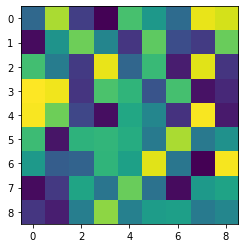

In [43]:
# for i in 
plt.imshow(model.layers[4].get_weights()[0][:,:,127,127])

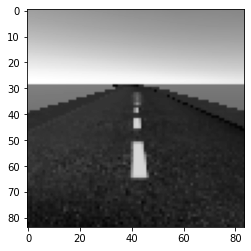

In [79]:
plt.imshow(state_history[0], cmap='gray')

In [47]:
resh.shape

(16384, 9, 9, 1)

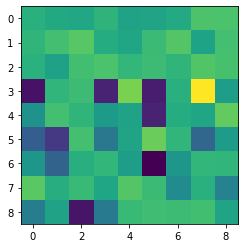

In [53]:
plt.imshow(resh[6, :,:,:])

In [26]:
env.close()